# 프로젝트 : 멋진 단어사전 만들기

## 1. SentencePiece 모델 만들기
- **학습용 데이터 준비하기**
- **모델 학습하기**

## 2. 데이터 준비하기
- **데이터 불러오기**
- **데이터 전처리**

## 3. 여러 모델 비교하기
- **SentencePiece(unigram)**
- **KoNLPy**
- **SentencePiece(bpe)**

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy

print(tf.__version__)
print(np.__version__)
print(plt.__version__)
print(konlpy.__version__)

2.6.0
1.21.4
3.4.3
0.5.2


- - -
### SentencePiece 모델 만들기
- **학습용 데이터 준비하기**

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

path_to_file = os.getenv('HOME') + '/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


데이터를 불러와줍니다.

이 데이터는 제 SentencePiece의 학습용 데이터로 쓰일 예정입니다.

문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 60


/tmp/ipykernel_3586/3813981591.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


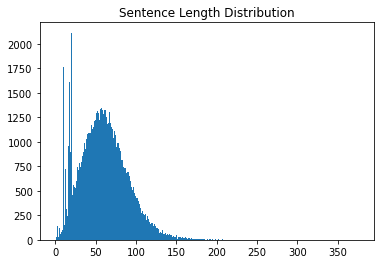

In [3]:
def show_sentence_length(raw):
    len_sen = [len(sen) for sen in raw]

    print("문장의 최단 길이:", min(len_sen))
    print("문장의 최장 길이:", max(len_sen))
    print("문장의 평균 길이:", sum(len_sen) // len(raw))

    max_len = max(len_sen)
    sentence_length = np.zeros((max_len), dtype=np.int)

    for i in range(max_len):
        sentence_length[i] = len_sen.count(i+1)

    plt.bar(range(max_len), sentence_length, width=1.0)
    plt.title("Sentence Length Distribution")
    plt.show()
    
    return sentence_length

sentence_length = show_sentence_length(raw)

문장의 길이 분포를 시각화하는 함수를 만들어줍시다.

문장의 길이가 1부터 최대 377까지 있으며 이상치가 몇 개 관측되는 것 빼곤

아름다운 모양의 분산을 보이고 있습니다.

In [4]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 50: return

check_sentence_with_length(raw, 1)

’


문장의 길이가 1인 문장은 `’` 하나 뿐인 다소 이상한 데이터가 섞여있었습니다.

In [5]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 11
Outlier Index: 19
Outlier Index: 21


문장의 수가 1500을 초과하는 문장 길이도 확인해봅시다.

In [6]:
check_sentence_with_length(raw, 11)

라고 조던이 말했다.
- 모르고 있습니다.
- 네, 보이는군요.
디즈니사만이 아니다.
큰 파티는 아니지요.
의자는 비어 있었다.
이 일은 계속됩니다.
나는 크게 실망했다.
그 이유는 간단하다.
이력서와 자기 소개서
시대가 변하고 있다.
는 돌발질문을 했다.
9. 몇 분간의 명상
하와이, 빅 아일랜드
키스를 잘 하는 방법
키스를 잘 하는 방법
스피어스가 뚱뚱한가?
산 위를 나는 느낌.
세 시간쯤 걸었을까?
(아직 읽고있습니까?
처음에는 장난이었다.
우리는 운이 좋았다.
아기가 숨을 멈출 때
건물 전체 무너져내려
그녀의 아름다운 눈.
대답은 다음과 같다.
"사과할 것이 없다.
폭탄테러가 공포 유발
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…


분포에 맞지 않게 관측되던 길이의 문장들은 중복된 데이터였기 때문이군요.

In [7]:
cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

Data Size: 77591


중복을 제거해줍니다.

문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


/tmp/ipykernel_3586/3813981591.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


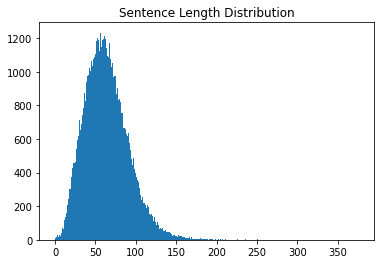

In [8]:
sentence_length = show_sentence_length(cleaned_corpus)

분포에서 이상치가 관측되던 부분이 사라졌습니다.

문장의 최단 길이: 10
문장의 최장 길이: 149
문장의 평균 길이: 64


/tmp/ipykernel_3586/3813981591.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


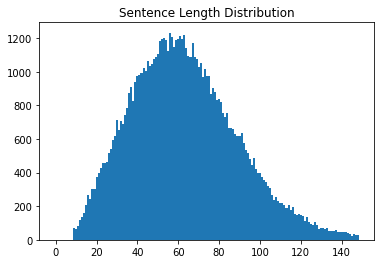

In [9]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = show_sentence_length(filtered_corpus)

분포가 적은 긴 문장의 데이터까지 활용하면 연산량이 비효율적으로 낭비되고,

길이가 너무 짧은 문장도 별 의미 없는 데이터일 확률이 크니까

최소 10, 최대 150의 길이를 가진 문장들로 추려낸 결과 분포가 훨씬 깔끔해졌습니다.

이제 중복 제거, 길이 필터링을 한 데이터를 가지고 SentencePiece를 학습시키겠습니다.

- - -
### SentencePiece 모델 만들기
- **모델 학습하기**

In [10]:
import sentencepiece as spm
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 376816 Nov 20 07:45 korean_spm.model
-rw-r--r-- 1 root root 146213 Nov 20 07:45 korean_spm.vocab


`vocab_size`는 8000으로, 처음 다뤄보는 것이니 옵션은 기본값인 `unigram`으로 진행하겠습니다.

In [11]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1243, 11, 302, 7, 3608, 11, 287, 38, 3]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


학습된 SentencePiece를 사용하면 위처럼 형태소가 분리가 되는군요.

쓸만한 정도는 되는 것 같습니다.

In [12]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

데이터를 받으면 텐서와 단어 사전으로 출력해주는 함수입니다.

In [13]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[1956 5665    5    4 7975 1990    3    0    0    0    0    0    0    0]
 [ 107 1641  101    4    0  417   11    4   14    0 1976    3    3    3]]


리스트 형태로 넣어보면서 함수를 테스트해보면 텐서 형태로 출력되는 것까지 잘 작동됩니다.

- - -
### 데이터 준비하기
- **데이터 불러오기**

In [14]:
# !mkdir -p ~/aiffel/GoingDeeper/dataset/sentiment_classification

In [15]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/GoingDeeper/dataset/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/GoingDeeper/dataset/sentiment_classification/ratings_test.txt')

print(train_data.shape)
print(test_data.shape)

train_data.head()

(150000, 3)
(50000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


그럼 제가 만든 SentencePiece와 KoNLPy를 비교 분석하기 위해 사용될 데이터를 준비해줍시다.

[네이버 영화 리뷰 감성 분석 태스크](https://github.com/e9t/nsmc/)입니다.

- - -
### 데이터 준비하기
- **데이터 전처리**

In [16]:
train_data.drop_duplicates(['document'], inplace=True)
train_data.dropna(how='any', inplace=True)

test_data.drop_duplicates(['document'], inplace=True)
test_data.dropna(how='any', inplace=True)

data = pd.concat([train_data, test_data], axis=0)

data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


간단하게 중복과 결측치를 제거해줍니다.

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


/tmp/ipykernel_3586/3813981591.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


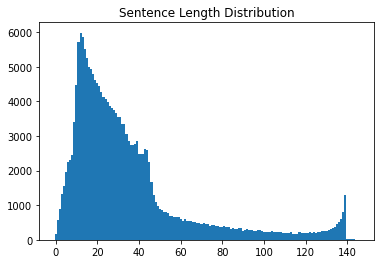

In [17]:
sentence_length = show_sentence_length(data['document'])

문장의 길이 분포를 살펴보면 아까의 데이터처럼 마냥 이쁜 모양은 아니네요.

In [18]:
for idx, _sum in enumerate(sentence_length):
    if _sum > 500 and idx > 135:
        print("Outlier Index:", idx+1)

Outlier Index: 137
Outlier Index: 138
Outlier Index: 139
Outlier Index: 140


분포의 마지막에 가장 우뚝 솟아있는 건 길이가 140인 문장들이겠네요.

어떻게 절묘하게 길이가 140인 문장이 많은걸까요?

In [19]:
check_sentence_with_length(data['document'], 140)

데너리스 타르 가르엔...나도 용의주인이 되고 싶다...누이랑,근친상간이나 하고 다닐지라도,소설 속에선 제일 멋진 놈이 자이메 라니스터였는데,드라마속에선,드래곤(용)이 제일 멋지네(웃음)감독님 토르-2 다크 월드는 말아 잡수셨을지라도,기본 선방은 했음
아~ 진짜 조금만 더 손 좀 보면 왠만한 상업 영화 못지 않게 퀄리티 쩔게 만들어 질 수 있었는데 아쉽네요 그래도 충분히 재미있었습니다 개인적으로 조금만 더 잔인하게 더 자극적으로 노출씬도 화끈하게 했더라면 어땠을까 하는 국산영화라 많이 아낀 듯 보임
평점조절위원회에서 나왔습니다(웃음)김혜선은 @내일이 오면@의 김순정,순정이 역할이 제일이다.팜므파탈로써,그 정도까지 잘해낼 줄은,정말 의외였어...연기20년 한사람에게 요즘 사극에서 벌어지고 있는,그녀에 대한 연기논란은 왠지 코미디의한장면 같음(웃음)
사실여부를 떠나,알고왔던 아더와 너무 매칭이 안돼더라.원탁기사중 실제 검술 최고수는 랜슬롯으로 알고 있는데,트리스탄보다 못하고,싸우는 검술은 마치 중국검술 흉내낸거 같은게;; 그리고 란슬롯이 실제는 쌍검였나?너무 매칭이 안대 하튼 ㅋ기네비어역도 미스.
진짜 이건 아님ㅋㅋㅋㅋㅋ액션영화좋아해서 액션영화만 다운받아서 꾸준히 본게 벌써 몇년인 사람임 근데 이건 진짴ㅋㅋㅋㅋㅋㅋ아무리 점수 잘 줘도 100점 만점에 10점?ㅡㅡ돈주고봤는데너무아깝다진짜ㅜㅜ그리고대체 왜 13구역 타이틀을 달고나왔는지 모르겠음 실망
영화'산업'이라고 하잖는가? 이딴식으로 홍보 해놓고 속여서 팔았다는 게 소비자 입장에서는 짜증난다. 그나마 다행은 아주 싸구려를 상급품으로 속여판 게 아니라는 점. 그래서 1점. 차라리 연상호 감독 작품 처럼 홍보가 됐다면, 그 비슷하게 만이라도 하지
화려한 색채때문에 눈이 아프지만 그 나름대로 화려연예계여자욕망에대해 표현해냈던거같다 보는내내 진짜 리리코심정가진 연옌들도 있을거같고..나를한번도보지못하고알지못하는사람들이날어떻게사랑하냐그런대사 나왔을때 소름돋더라 연예인들은 많은사랑받으면서도 참 허전할듯
히가시노 게이고의 추리소

..그냥 우연의 일치라고 보겠습니다.

데이터를 확인하는 입장인 저로썬 확인하기가 힘들군요.

In [20]:
data.loc[data['id'] == 8355974]

,id,document,label
34069,8355974,"와.,.,.,..진짜 최악이다.,.,.,.,.와,.,.,.,. 이영화랑 클레멘타인의...",0


데이터를 이리저리 둘러보다 우연히 찾은 요주의 문장입니다.

어떻게 말줄임표를 `,`과 `.`을 번갈아서 쓸 생각을 했는지..

아무튼 이 문장을 중점적으로 전처리를 진행하겠습니다.

In [21]:
import re

def preprocess_sentence(sentence):
    sentence = re.sub(r"[^a-zA-Z0-9\uAC00-\uD7A3\s~!?,.']+", '', sentence) # a-z : 모든 알파벳 소문자
                                                                            # A-Z : 모든 알파벳 대문자
                                                                            # 0-9 : 모든 숫자
                                                                            # \uAC00-\uD7A3 : 모든 한글
                                                                            # \s : 공백
                                                                            # ~!?,.' : 예외시킨 특수문자들
    sentence = re.sub(r'[" "]+', " ", sentence) # 공백 중복은 하나의 공백으로
    sentence = re.sub(r'["!"]+', "!", sentence) # 느낌표 중복은 하나의 느낌표로
    sentence = re.sub(r'["?"]+', "?", sentence) # 물음표 중복은 하나의 물음표로
    sentence = re.sub(r'["~"]+', "~", sentence) # 물결표 중복은 하나의 물결표로
    sentence = re.sub(r'[",."]{2}', "..", sentence) # ,,이나 ,이 섞인 말줄임표는 ..으로
    sentence = re.sub(r'["."]{2,}', "..", sentence) # .이 두 개 이상 반복되는 말줄임표는 ..으로
    sentence = re.sub(r'["O"]{2,}', "", sentence) # OO로 필터링(추정)된 것은 제거
    sentence = sentence.strip()
    
    return sentence

train_data['document'] = train_data['document'].apply(preprocess_sentence)
test_data['document'] = test_data['document'].apply(preprocess_sentence)

data = pd.concat([train_data, test_data], axis=0)

data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠..포스터보고 초딩영화줄..오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따,0
49997,9072549,그림도 좋고 완성도도 높았지만.. 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


전처리 함수입니다.

`!!, ??, ~~`와 같은 하나여도 상관 없는 감탄사는 하나만 사용하도록 줄여줬고,

`,`을 이용한 말줄임표는 모두 `..`으로 통일해주면서 `,`이 하나만 있을 경우엔 처리되지 않게 해줬습니다.

그리고 말줄임표도 `.`이 2개든 10개든 의미에는 큰 차이가 없으므로 `.`을 두 개 쓰는 것으로 통일해줬구요.

마지막으로 `OOOO` 이런 단어가 있었는데, 혹시 데이터셋을 만든 사람이 필터링을 했거나 네이버에서 자동적으로 필터링 되게끔 한 단어가 아닐까 싶었고, 

만약 그렇다면 의미가 없는 단어이니 제거해줬습니다.

문장의 최단 길이: 0
문장의 최장 길이: 140
문장의 평균 길이: 34


/tmp/ipykernel_3586/3813981591.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


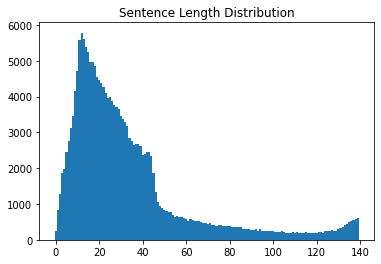

In [22]:
sentence_length = show_sentence_length(data['document'])

전처리 결과 최단 길이가 1 → 0, 최장 길이가 146 → 140, 평균 길이가 35 → 34로

분포의 모양 또한 큰 차이가 없을 정도로 문장 자체는 크게 건드리지 않았습니다.

In [23]:
data.loc[data['id'] == 8355974]

,id,document,label
34069,8355974,와..진짜 최악이다..와.. 이영화랑 클레멘타인의 차이점은..이영화는 돈을 좀더 썼...,0


제가 찾았던 요주의 데이터를 보니 깔끔하게 처리가 됐습니다.(뿌듯)

In [24]:
min_len = 1
max_len = 55

data.loc[data['document'].apply(lambda x: not (min_len <= len(x) <= max_len))]

,id,document,label
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
14,9864035,취향은 존중한다지만 진짜 내생에 극장에서 본 영화중 가장 노잼 노감동임 스토리도 어...,0
16,9143163,참 사람들 웃긴게 바스코가 이기면 락스코라고 까고바비가 이기면 아이돌이라고 깐다.그...,1
22,9705777,재미없다 지루하고. 같은 음식 영화인데도 바베트의 만찬하고 넘 차이남..바베트의 만...,0
...,...,...,...
49954,8787645,5편의 존 무어 감독은 만약에 6편을 만든다 하면 4편까진 복습하고 오시길!그게 뭡...,1
49970,6833821,당신의 꿈은 지금 안녕하신가요.. 유쾌하고 감동적이고 꿈을 잊고 사는 현대인들이 보...,1
49973,8527261,영화 초반 존쿠삭이 바네사 허진스 가두고 LP로 틀던 팝송 정말 좋던데 아시는분 제...,0
49974,6694209,그래서 하고 싶은 말이 뭔데..? . 연출만 잘했더라면 훨씬 더 흥미로웠을텐데. 몇...,0


문장의 최소 길이를 1, 최대 길이를 55로 설정할 경우 제거될 데이터 목록입니다.

확인 결과 별 영향 없을 것으로 보입니다.

In [25]:
train_data = train_data.loc[train_data['document'].apply(lambda x: min_len <= len(x) <= max_len)]
test_data = test_data.loc[test_data['document'].apply(lambda x: min_len <= len(x) <= max_len)]

data = pd.concat([train_data, test_data], axis=0)

data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠..포스터보고 초딩영화줄..오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화..별반개도 아까움.,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따,0
49997,9072549,그림도 좋고 완성도도 높았지만.. 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


필터링 후 데이터입니다.

train과 test를 합쳐 총 *165452*개가 남았습니다.

문장의 최단 길이: 1
문장의 최장 길이: 55
문장의 평균 길이: 24


/tmp/ipykernel_3586/3813981591.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


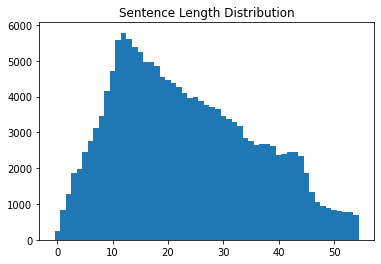

In [26]:
sentence_length = show_sentence_length(data['document'])

분포도 확인해봅시다.

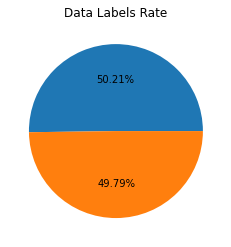

In [27]:
plt.pie(data['label'].value_counts(), autopct='%.2f%%')
plt.title('Data Labels Rate')
plt.show()

지금까지의 전처리를 거치면서 혹시 특정 레이블 위주로 제거되진 않았는지 레이블의 비율을 확인해봤습니다.

다행히 정상입니다.

- - -
### 여러 모델 비교하기
- **SentencePiece(unigram)**

In [28]:
sp_data, word_index, index_word = sp_tokenize(s, data['document'])

sp_data

array([[ 141,  106, 2611, ...,    0,    0,    0],
       [   4, 7663,    3, ...,    0,    0,    0],
       [1328,  437,    0, ...,    0,    0,    0],
       ...,
       [4410,   30,    4, ...,    0,    0,    0],
       [4228,    4, 6173, ...,    0,    0,    0],
       [2933,   10,  157, ...,    0,    0,    0]], dtype=int32)

첫 번째로 SentencePiece을 unigram으로 학습한 모델입니다.

train과 test가 서로 같은 단어 사전을 공유해야 하기 때문에

train과 test를 하나로 묶은 데이터로 텐서를 생성해줬습니다.

In [29]:
min([sum(tensor) for tensor in sp_data])

4

혹시 `vocab_size`에 의해 모든 문장이 0(`PAD 또는 UNK`)으로 처리된 데이터는 없는지 확인해봤습니다.

In [30]:
sp_train = sp_data[:len(train_data)]
sp_test = sp_data[-len(test_data):]

원래 train과 test 데이터를 분리해줍니다.

In [31]:
labels_train = np.asarray(train_data['label']).astype('float32')
labels_test = np.asarray(test_data['label']).astype('float32')

레이블도 준비해줍니다.

    타입이 실수여야 모델에 들어갔을 때 오류가 발생하지 않습니다.

In [32]:
print(sp_train.shape)
print(labels_train.shape)
print(sp_test.shape)
print(labels_test.shape)

(123860, 53)
(123860,)
(41592, 53)
(41592,)


꼬인 데이터 없이 모두 잘 처리된 것 같습니다.

In [33]:
for i, sen in enumerate(sp_train[:15]):
    print([index_word[idx] for idx in sen if index_word[idx] != '<unk>'], labels_train[i])

['▁아', '▁더', '빙', '.', '.', '▁진', '짜', '▁', '짜', '증', '나', '네', '요', '▁목소리'] 0.0
['▁', '흠', '.', '.', '포', '스터', '보', '고', '▁초', '딩', '영화', '줄', '.', '.', '오', '버', '연', '기', '조차', '▁', '가', '볍', '지', '▁않', '구', '나'] 1.0
['▁너무', '재', '었다', '그', '래', '서', '보', '는', '것', '을', '추', '천', '한다'] 0.0
['▁교도소', '▁이야기', '구', '먼', '▁', '.', '.', '솔', '직', '히', '▁재', '미', '는', '▁없다', '.', '.', '평', '점', '▁조정'] 0.0
['▁막', '▁걸', '음', '마', '▁', '▁3', '세', '부터', '▁초', '등', '학교', '▁1', '학', '년', '생', '인', '▁8', '살', '용', '영화', '.', '.', '별', '반', '개', '도', '▁아', '까', '움', '.'] 0.0
['▁원', '작', '의', '▁긴장', '감', '을', '▁', '제대로', '▁살', '려', '내', '지', '못', '했다', '.'] 0.0
['▁', '액', '션', '이', '▁없는', '데', '도', '▁재', '미', '▁있는', '▁몇', '안', '되는', '▁영화'] 1.0
['▁왜', '케', '▁평', '점', '이', '▁낮은', '건', '데', '?', '▁', '꽤', '▁볼', '만한', '데', '.', '.', '▁', '헐', '리', '우드', '식', '▁화려', '함', '에', '만', '▁너무', '▁길', '들', '여', '져', '▁있', '나', '?'] 1.0
['▁', '인', '피', '니', '트', '가', '이다', '.', '진', '짜', '이다'] 1.0
['▁볼', '때', '

모델에 넣기 전 SentencePiece가 데이터를 어떻게 분리를 했는지 한 번 확인해봤습니다.

음.. 거의 음절 단위로 분리된 느낌이 강한데.. SentencePiece의 학습이 충분하지 않아서 생긴 문제겠죠?

그래도 일단 모델에 넣고 돌려봅시다.

In [34]:
val_num = 20000

X_train = sp_train[:-val_num]
y_train = labels_train[:-val_num]

X_val = sp_train[-val_num:]
y_val = labels_train[-val_num:]

print(X_train.shape)
print(X_val.shape)

(103860, 53)
(20000, 53)


밸리데이션 데이터는 뒤에서 2만 개의 데이터로 해주겠습니다.

In [35]:
def print_result(results):
    loss = results[0]
    acc = results[1]
    print(f'test_loss : {loss} test_acc : {acc}')


def history_graph(history):
    plt.figure(figsize=(12,4))
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plt.subplot(1, 2, 1)
    plt.plot(loss, 'ko', label='Training loss')
    plt.plot(val_loss, 'c', label='Validation loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(acc, 'ko', label='Training acc')
    plt.plot(val_acc, 'c', label='Validation acc')
    plt.title('Training & Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

이건 제가 EXP-08 프로젝트를 할 때 만들었던 함수입니다. ~~재탕해줍시다.~~

In [36]:
word_vector_dim = 53

tf.random.set_seed(1337) # 시드 1337 고정

model = tf.keras.Sequential() # RNN
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3)) # 드랍아웃 추가
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 53)          424000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                4480      
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 428,769
Trainable params: 428,769
Non-trainable params: 0
_________________________________________________________________


`vocab_size`는 8000 그대로, 임베딩 아웃풋은 문장의 길이에 맞춰주고 간단하게 모델을 설계했습니다. ~~이것도 재탕~~

In [37]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5)

Epoch 1/15
203/203 [==============================] - 5s 8ms/step - loss: 0.6932 - accuracy: 0.4980 - val_loss: 0.6932 - val_accuracy: 0.4994
Epoch 2/15
203/203 [==============================] - 1s 6ms/step - loss: 0.6932 - accuracy: 0.4992 - val_loss: 0.6932 - val_accuracy: 0.4994
Epoch 3/15
203/203 [==============================] - 1s 6ms/step - loss: 0.6932 - accuracy: 0.4990 - val_loss: 0.6932 - val_accuracy: 0.4994
Epoch 4/15
203/203 [==============================] - 1s 6ms/step - loss: 0.6794 - accuracy: 0.5370 - val_loss: 0.5657 - val_accuracy: 0.7430
Epoch 5/15
203/203 [==============================] - 1s 6ms/step - loss: 0.4614 - accuracy: 0.7982 - val_loss: 0.4176 - val_accuracy: 0.8069
Epoch 6/15
203/203 [==============================] - 1s 6ms/step - loss: 0.3955 - accuracy: 0.8283 - val_loss: 0.3971 - val_accuracy: 0.8196
Epoch 7/15
203/203 [==============================] - 1s 6ms/step - loss: 0.3717 - accuracy: 0.8387 - val_loss: 0.3877 - val_accuracy: 0.8253
Epoch 

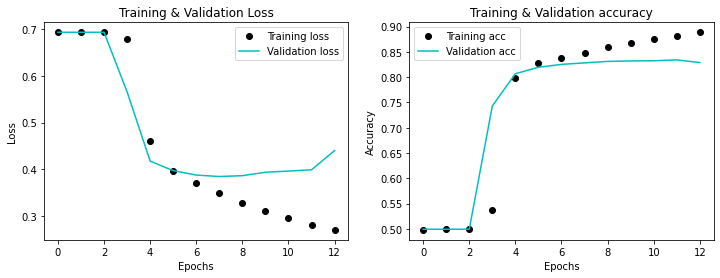

1300/1300 - 3s - loss: 0.4428 - accuracy: 0.8320
test_loss : 0.4428175985813141 test_acc : 0.8319869041442871


In [38]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 15

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[es]
                    )

history_graph(history)

results = model.evaluate(sp_test,  labels_test, verbose=2)
print_result(results)

배치 사이즈는 512, 얼리스탑핑을 적용하고 모델 학습 결과 약 83%의 정확도를 보여줍니다.

분리됐던 문장의 퀄리티와는 다르게 나름 준수한 결과입니다.

- - -
### 여러 모델 비교하기
- **KoNLPy**

그렇다면 KoNLPy 모듈을 불러와서 본격적으로 SentencePiece와 비교를 해보도록 하죠.

In [39]:
data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠..포스터보고 초딩영화줄..오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화..별반개도 아까움.,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따,0
49997,9072549,그림도 좋고 완성도도 높았지만.. 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


데이터를 불러오면 문장의 길이를 필터링한 직후의 데이터가 그대로 남아있습니다.

KoNLPy에선 다양한 형태소 분석기 모델을 제공하는데요.

아직 완벽하다고 하는 모델도 없고, 데이터셋에 따라 좋은 분석기 모델이 달라지는 모양이니

Meacb, Kkma, Okt 세 가지를 불러와서 비교해보고 사용하겠습니다.

In [40]:
sample_sentence = data['document'].sample(15)

sample_sentence

5558                          트레져헌터영화라이만 이건 아니잖아!
44764              기괴함이 알러지 반응을 유발한다면 그 원인을 분석할 것
25382                        너무 좋다.. 배경음악 진짜 좋다..
12687                        드라마조차 별로인 그야말로 엉터리영화
123860                    정말 영화같지않은영화 차라리 독립영화가나음
107361                                     재밌다.정말
46500                                    김동욱 화이팅!
63295             이명작이b급7급공무원이랑 같은 점수라니9점짜리 영화입니다
108305      한적한 곳의 풍광과 그곳의 긴장감, ..떡삽겹살파티..먹음직스럽다.
119718                         봐야하는 영화. 다른말이 필요없다
36191     시다미라이에대한 애정으로 일단10점. 하지만 영화자체엔 실망 죄송합니다
36533                토이스토리를 보면서 자란 세대들이라면 잊을수가 없다
39087                      볼만함 평점 넘 낮아서 기대안하고 봤능데
124768                       엠마 로버츠 나오니까 9점 드릴께여.
120221          어설픈 원스 분위기..하지만 음악 영화라고 할 수는 없다..
Name: document, dtype: object

비교 실험의 샘플 문장을 15개 뽑아줍니다.

In [41]:
from konlpy.tag import Mecab, Kkma, Okt

sample_Mecab = sample_sentence.apply(Mecab().morphs)
sample_Kkma = sample_sentence.apply(Kkma().morphs)
sample_Okt = sample_sentence.apply(Okt().morphs)

In [42]:
print(sample_Mecab)

5558                    [트레져, 헌터, 영화, 라이, 만, 이건, 아니, 잖아, !]
44764     [기괴, 함, 이, 알, 러지, 반응, 을, 유발, 한다면, 그, 원인, 을, 분석...
25382              [너무, 좋, 다, ., ., 배경, 음악, 진짜, 좋, 다, ., .]
12687                       [드라마, 조차, 별로, 인, 그야말로, 엉터리, 영화]
123860         [정말, 영화, 같, 지, 않, 은, 영화, 차라리, 독립영화, 가, 나, 음]
107361                                       [재밌, 다, ., 정말]
46500                                         [김동욱, 화이팅, !]
63295     [이, 명작, 이, b, 급, 7, 급, 공무원, 이랑, 같, 은, 점수, 라니, ...
108305    [한적, 한, 곳, 의, 풍광, 과, 그곳, 의, 긴장감, ,, .., 떡, 삽, ...
119718                [봐야, 하, 는, 영화, ., 다른, 말, 이, 필요, 없, 다]
36191     [시다미라이, 에, 대한, 애정, 으로, 일단, 10, 점, ., 하지만, 영화, ...
36533     [토이, 스토리, 를, 보, 면서, 자란, 세대, 들, 이, 라면, 잊, 을, 수,...
39087         [볼, 만, 함, 평점, 넘, 낮, 아서, 기대, 안, 하, 고, 봤, 능, 데]
124768                 [엠마, 로버츠, 나오, 니까, 9, 점, 드릴, 께, 여, .]
120221    [어설픈, 원스, 분위기, ., ., 하지만, 음악, 영화, 라고, 할, 수, 는,...
Name: document, dtype: object


In [43]:
print(sample_Kkma)

5558          [트레, 지, 어, 허, ㄴ, 터, 영화, 라이만, 이, 건, 아니, 잖아, !]
44764     [기괴, 하, ㅁ, 이, 알, ㄹ, 러지, 반응, 을, 유발, 하, ㄴ다면, 그, ...
25382                  [너무, 좋, 다, .., 배경, 음악, 진짜, 좋, 다, ..]
12687                       [드라마, 조차, 별로, 인, 그야말로, 엉터리, 영화]
123860    [정말, 영화, 같, 지, 않, 은, 영화, 차라리, 독립, 영화, 가, 나, 아, 음]
107361                                       [재밌, 다, ., 정말]
46500                                       [김동욱, 화이, 팅, !]
63295     [이명, 작, 이, b, 급, 7, 급, 공무원, 이랑, 같, 은, 점수, 라니, ...
108305    [한적, 하, ㄴ, 곳, 의, 풍광, 과, 그곳, 의, 긴장감, ,, .., 떡, ...
119718            [보, 아야, 하, 는, 영화, ., 다르, ㄴ, 말, 이, 필요없, 다]
36191     [시다, 미, 라이, 에, 대하, ㄴ, 애정, 으로, 일단, 10, 점, ., 하지...
36533     [토이, 스토리, 를, 보, 면서, 자라, ㄴ, 세대, 들, 이, 라면, 잊, 을,...
39087          [볼만, 하, ㅁ, 평점, 넘, 낮, 아서, 기대, 안, 하, 고, 봤능, 델]
124768               [엠, 마, 로버츠, 나오, 니까, 9, 점, 드릴, 께, 여, .]
120221    [어설프, ㄴ, 원스, 분위기, .., 하지만, 음악, 영화, 라고, 하, ㄹ, 수...
Name: document, dtype: object


In [44]:
print(sample_Okt)

5558                    [트레, 져, 헌터, 영화, 라이, 만, 이건, 아니잖아, !]
44764       [기괴함이, 알러지, 반응, 을, 유발, 한다면, 그, 원인, 을, 분석, 할, 것]
25382                        [너무, 좋다, .., 배경음악, 진짜, 좋다, ..]
12687                       [드라마, 조차, 별로, 인, 그야말로, 엉터리, 영화]
123860               [정말, 영화, 같지, 않은, 영화, 차라리, 독립영화, 가나, 음]
107361                                         [재밌다, ., 정말]
46500                                         [김동욱, 화이팅, !]
63295     [이, 명작, 이, b, 급, 7, 급공무원, 이랑, 같은, 점수, 라니, 9, 점...
108305    [한적한, 곳, 의, 풍, 광, 과, 그, 곳, 의, 긴장감, ,, .., 떡삽겹살...
119718                      [봐, 야하는, 영화, ., 다른, 말, 이, 필요없다]
36191     [시, 다미, 라이, 에, 대한, 애정, 으로, 일단, 10, 점, ., 하지만, ...
36533               [토이스토리, 를, 보면서, 자란, 세대, 들이라면, 잊을수가, 없다]
39087               [볼, 만, 함, 평점, 넘, 낮아서, 기, 대안, 하고, 봤, 능데]
124768                       [엠마, 로버츠, 나오니까, 9, 점, 드릴께여, .]
120221    [어설픈, 원스, 분위기, .., 하지만, 음악, 영화, 라고, 할, 수, 는, 없...
Name: document, dtype: object


종합적인 평가를 내려보면 먼저 Kkma는 받침이 자꾸 분리가 되네요. 때문에 좋은 결과를 기대하지 못할 것 같습니다.

그럼 Mecab과 Okt 둘 중 어느 것이 더 좋은가인데요.

분리된 형태로만 봤을 때는 개인적으로 Okt가 더 결과가 좋지 않나 라는 생각이 들지만(특히 `.`과 `..`을 다르게 보는 것에서 차이가 발생)

Mecab과의 큰 차이는 별로 없는 것 같아서 둘 다 모델에 넣어봐야 알 것 같습니다.

### *Okt*

In [45]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

Okt_data, tokenizer = tokenize(data['document'].apply(Okt().morphs))

Okt_data

array([[  46,  451,    1, ...,    0,    0,    0],
       [ 706,    1,  375, ...,    0,    0,    0],
       [ 342, 2357, 5460, ...,    0,    0,    0],
       ...,
       [ 861,    9,  293, ...,    0,    0,    0],
       [ 367,  250, 2398, ...,    0,    0,    0],
       [ 891,   11,  136, ...,    0,    0,    0]], dtype=int32)

Okt로 토큰화한 데이터를 `Okt_data`라고 정해주겠습니다.

    keras의 Tokenizer를 사용하면 강제로 공백 기반 토큰화가 되는 것이 아닌가? 싶었는데
    형태소 토큰화를 마친 후에 넣으면 이미 공백이 제거되고 없기 때문에 문제가 없겠더라구요.

In [46]:
min([sum(tensor) for tensor in Okt_data])

0

이번에는 vocab_size에 의해 모든 문장이 0(PAD 또는 UNK)으로 처리된 데이터가 발생했습니다.~~ㅇㄴ~~

결측치와 마찬가지므로 제거해줘야 합니다.

In [47]:
len(Okt_data)

165452

혹시 데이터가 잘못될 수 있으니 전체 데이터의 수를 확인해줍시다.

In [48]:
[sum(tensor) for tensor in Okt_data].count(0)

1079

지워야 할 데이터는 *1079*개입니다.

In [49]:
len([tensor for tensor in Okt_data if sum(tensor) > 0])

164373

제거를 하면 *165452*개에서 *1079*개를 뺀 *164373*개가 되야합니다.

In [50]:
data['okt'] = Okt_data.tolist()

data

,id,document,label,okt
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,"[46, 451, 1, 22, 6717, 694, 0, 0, 0, 0, 0, 0, ..."
1,3819312,흠..포스터보고 초딩영화줄..오버연기조차 가볍지 않구나,1,"[706, 1, 375, 52, 500, 3, 206, 1, 1542, 32, 10..."
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[342, 2357, 5460, 182, 21, 20, 0, 0, 0, 0, 0, ..."
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,"[7347, 117, 7711, 1, 234, 51, 11, 79, 1, 27, 3..."
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화..별반개도 아까움.,0,"[864, 893, 105, 431, 163, 1952, 42, 1993, 410,..."
...,...,...,...,...
49995,4608761,오랜만에 평점 로긴했네 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1,"[273, 23, 7, 27, 28, 970, 1937, 5230, 21, 3, 1..."
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따,0,"[2476, 12, 167, 14, 933, 125, 3726, 643, 0, 0,..."
49997,9072549,그림도 좋고 완성도도 높았지만.. 보는 내내 불안하게 만든다,0,"[861, 9, 293, 842, 6291, 1, 118, 299, 1501, 0,..."
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0,"[367, 250, 2398, 41, 493, 3, 1, 51, 9, 130, 26..."


제거를 하면서 중요한 것은 레이블 데이터가 꼬이지 않게 제거하는 것입니다.

그러기 위해서 일단 데이터프레임에 텐서 컬럼을 추가해주고 레이블과 같이 제거되도록 해주겠습니다.

In [51]:
Okt_train_data = data[:len(train_data)]
Okt_test_data = data[-len(test_data):]

데이터가 합쳐진 채로 제거하면 또 어디부터가 학습용이고 테스트용 데이터인지 헷갈릴테니

train과 test를 분리한 후에 제거를 진행하겠습니다.

In [52]:
Okt_train_data = Okt_train_data.iloc[[i for i, tensor in enumerate(Okt_data[:len(train_data)]) if sum(tensor) > 0]]
Okt_test_data = Okt_test_data.iloc[[i for i, tensor in enumerate(Okt_data[-len(test_data):]) if sum(tensor) > 0]]

iloc을 이용해 제거될 인덱스인지 아닌지를 판단해 제거해줬습니다.

    apply(lambda x: sum(x) > 0)을 하면 'unhashable type list' 오류가 나며 안됐습니다.
    이유는 list, dict을 넣으면 뭔가 충돌이 일어난다고 하네요

In [53]:
Okt_data = pd.concat([Okt_train_data, Okt_test_data], axis=0)

Okt_data

,id,document,label,okt
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,"[46, 451, 1, 22, 6717, 694, 0, 0, 0, 0, 0, 0, ..."
1,3819312,흠..포스터보고 초딩영화줄..오버연기조차 가볍지 않구나,1,"[706, 1, 375, 52, 500, 3, 206, 1, 1542, 32, 10..."
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[342, 2357, 5460, 182, 21, 20, 0, 0, 0, 0, 0, ..."
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,"[7347, 117, 7711, 1, 234, 51, 11, 79, 1, 27, 3..."
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화..별반개도 아까움.,0,"[864, 893, 105, 431, 163, 1952, 42, 1993, 410,..."
...,...,...,...,...
49995,4608761,오랜만에 평점 로긴했네 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1,"[273, 23, 7, 27, 28, 970, 1937, 5230, 21, 3, 1..."
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따,0,"[2476, 12, 167, 14, 933, 125, 3726, 643, 0, 0,..."
49997,9072549,그림도 좋고 완성도도 높았지만.. 보는 내내 불안하게 만든다,0,"[861, 9, 293, 842, 6291, 1, 118, 299, 1501, 0,..."
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0,"[367, 250, 2398, 41, 493, 3, 1, 51, 9, 130, 26..."


제거 후 *164373*개인 것을 보니 잘 제거된 것 같습니다.

In [54]:
Okt_train = np.array(list(Okt_train_data['okt']))
Okt_test = np.array(list(Okt_test_data['okt']))

labels_train = np.asarray(Okt_train_data['label']).astype('float32')
labels_test = np.asarray(Okt_test_data['label']).astype('float32')

print(Okt_train.shape)
print(labels_train.shape)
print(Okt_test.shape)
print(labels_test.shape)

(123070, 40)
(123070,)
(41303, 40)
(41303,)


이전에 했던 것처럼 train과 test를 준비해줍니다.

    list(Okt_train_data['okt'])를 해주지 않으면 1차원 모습의 리스트만 들어가면서 모델에 입력이 안됐습니다.

In [55]:
val_num = 20000

X_train = Okt_train[:-val_num]
y_train = labels_train[:-val_num]

X_val = Okt_train[-val_num:]
y_val = labels_train[-val_num:]

print(X_train.shape)
print(X_val.shape)

(103070, 40)
(20000, 40)


밸리데이션도 마찬가지로 2만 개의 데이터를 사용해주겠습니다.

In [56]:
word_vector_dim = 40

tf.random.set_seed(1337) # 시드 1337 고정

model = tf.keras.Sequential() # RNN
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3)) # 드랍아웃 추가
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 40)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3648      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 323,937
Trainable params: 323,937
Non-trainable params: 0
_________________________________________________________________


아웃풋을 문장의 길이인 40으로 변경하고 나머지는 이전 모델과 같습니다.

Epoch 1/15
202/202 [==============================] - 8s 18ms/step - loss: 0.6931 - accuracy: 0.5045 - val_loss: 0.6848 - val_accuracy: 0.7184
Epoch 2/15
202/202 [==============================] - 1s 6ms/step - loss: 0.4675 - accuracy: 0.7988 - val_loss: 0.3849 - val_accuracy: 0.8302
Epoch 3/15
202/202 [==============================] - 1s 6ms/step - loss: 0.3539 - accuracy: 0.8511 - val_loss: 0.3650 - val_accuracy: 0.8417
Epoch 4/15
202/202 [==============================] - 1s 6ms/step - loss: 0.3316 - accuracy: 0.8594 - val_loss: 0.3661 - val_accuracy: 0.8400
Epoch 5/15
202/202 [==============================] - 1s 6ms/step - loss: 0.3198 - accuracy: 0.8630 - val_loss: 0.3724 - val_accuracy: 0.8399
Epoch 6/15
202/202 [==============================] - 1s 6ms/step - loss: 0.3074 - accuracy: 0.8664 - val_loss: 0.3776 - val_accuracy: 0.8403
Epoch 7/15
202/202 [==============================] - 1s 6ms/step - loss: 0.2949 - accuracy: 0.8689 - val_loss: 0.3928 - val_accuracy: 0.8397
Epoch

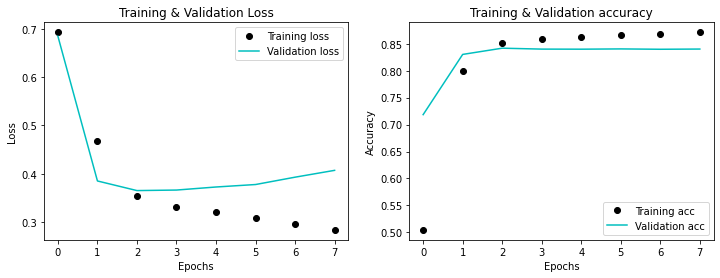

1291/1291 - 3s - loss: 0.4130 - accuracy: 0.8368
test_loss : 0.4129945635795593 test_acc : 0.8368157148361206


In [57]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 15

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[es]
                    )

history_graph(history)

results = model.evaluate(Okt_test,  labels_test, verbose=2)
print_result(results)

학습이 더 빨리 진행되면서 더 높은 정확도가 나왔습니다.

그렇다고 해서 KoNLPy의 모듈이 SentencePiece를 사용한 것보다 좋다라는 결론은 아닙니다.

제가 만든 SentencePiece는 간이 형태소 분리기에 불과했으니까요.

### *Mecab*

In [58]:
Mecab_data, tokenizer = tokenize(data['document'].apply(Mecab().morphs))
data['mecab'] = Mecab_data.tolist()

Mecab_train_data = data[:len(train_data)]
Mecab_test_data = data[-len(test_data):]

Mecab_train_data = Mecab_train_data.iloc[[i for i, tensor in enumerate(Mecab_data[:len(train_data)]) if sum(tensor) > 0]]
Mecab_test_data = Mecab_test_data.iloc[[i for i, tensor in enumerate(Mecab_data[-len(test_data):]) if sum(tensor) > 0]]

Mecab_data = pd.concat([Mecab_train_data, Mecab_test_data], axis=0)

Mecab_data

,id,document,label,okt,mecab
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,"[46, 451, 1, 22, 6717, 694, 0, 0, 0, 0, 0, 0, ...","[37, 80, 882, 1, 1, 41, 222, 26, 42, 759, 0, 0..."
1,3819312,흠..포스터보고 초딩영화줄..오버연기조차 가볍지 않구나,1,"[706, 1, 375, 52, 500, 3, 206, 1, 1542, 32, 10...","[814, 1, 1, 440, 504, 555, 3, 130, 1, 1, 1503,..."
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[342, 2357, 5460, 182, 21, 20, 0, 0, 0, 0, 0, ...","[29, 159, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,"[7347, 117, 7711, 1, 234, 51, 11, 79, 1, 27, 3...","[6659, 162, 2745, 1, 1, 289, 81, 4, 20, 5, 1, ..."
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화..별반개도 아까움.,0,"[864, 893, 105, 431, 163, 1952, 42, 1993, 410,...","[763, 138, 404, 205, 1547, 666, 71, 1766, 652,..."
...,...,...,...,...,...
49995,4608761,오랜만에 평점 로긴했네 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1,"[273, 23, 7, 27, 28, 970, 1937, 5230, 21, 3, 1...","[339, 12, 54, 43, 202, 48, 40, 4261, 3815, 204..."
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따,0,"[2476, 12, 167, 14, 933, 125, 3726, 643, 0, 0,...","[2242, 19, 244, 7, 4, 56, 5, 11, 961, 228, 149..."
49997,9072549,그림도 좋고 완성도도 높았지만.. 보는 내내 불안하게 만든다,0,"[861, 9, 293, 842, 6291, 1, 118, 299, 1501, 0,...","[903, 10, 23, 6, 1376, 10, 245, 52, 47, 1, 1, ..."
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0,"[367, 250, 2398, 41, 493, 3, 1, 51, 9, 130, 26...","[414, 464, 4, 38, 320, 3, 1, 1, 81, 10, 20, 6,..."


그럼 Okt와 비슷한 성능으로 형태소가 분리되었던 Mecab도 한 번 써보겠습니다.

빠르게 결측치 제거까지 모두 진행했습니다.

Okt와 성능은 큰 차이가 없어보였는데 처리 속도 측면에선 Mecab이 눈에 띄게 빠르군요.

In [59]:
Mecab_train = np.array(list(Mecab_train_data['mecab']))
Mecab_test = np.array(list(Mecab_test_data['mecab']))

labels_train = np.asarray(Mecab_train_data['label']).astype('float32')
labels_test = np.asarray(Mecab_test_data['label']).astype('float32')

print(Mecab_train.shape)
print(labels_train.shape)
print(Mecab_test.shape)
print(labels_test.shape)

(123528, 48)
(123528,)
(41447, 48)
(41447,)


In [60]:
val_num = 20000

X_train = Mecab_train[:-val_num]
y_train = labels_train[:-val_num]

X_val = Mecab_train[-val_num:]
y_val = labels_train[-val_num:]

print(X_train.shape)
print(X_val.shape)

(103528, 48)
(20000, 48)


In [61]:
word_vector_dim = 48

tf.random.set_seed(1337) # 시드 1337 고정

model = tf.keras.Sequential() # RNN
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3)) # 드랍아웃 추가
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 48)          384000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 388,449
Trainable params: 388,449
Non-trainable params: 0
_________________________________________________________________


마찬가지로 임베딩 아웃풋을 제외한 나머지는 모두 같습니다.

Epoch 1/15
203/203 [==============================] - 4s 12ms/step - loss: 0.6932 - accuracy: 0.5028 - val_loss: 0.6931 - val_accuracy: 0.5007
Epoch 2/15
203/203 [==============================] - 1s 6ms/step - loss: 0.5128 - accuracy: 0.7387 - val_loss: 0.3696 - val_accuracy: 0.8415
Epoch 3/15
203/203 [==============================] - 2s 10ms/step - loss: 0.3507 - accuracy: 0.8546 - val_loss: 0.3508 - val_accuracy: 0.8477
Epoch 4/15
203/203 [==============================] - 1s 6ms/step - loss: 0.3250 - accuracy: 0.8653 - val_loss: 0.3677 - val_accuracy: 0.8339
Epoch 5/15
203/203 [==============================] - 1s 6ms/step - loss: 0.3036 - accuracy: 0.8739 - val_loss: 0.3520 - val_accuracy: 0.8529
Epoch 6/15
203/203 [==============================] - 1s 6ms/step - loss: 0.2796 - accuracy: 0.8844 - val_loss: 0.3457 - val_accuracy: 0.8535
Epoch 7/15
203/203 [==============================] - 1s 6ms/step - loss: 0.2615 - accuracy: 0.8925 - val_loss: 0.3628 - val_accuracy: 0.8564
Epoc

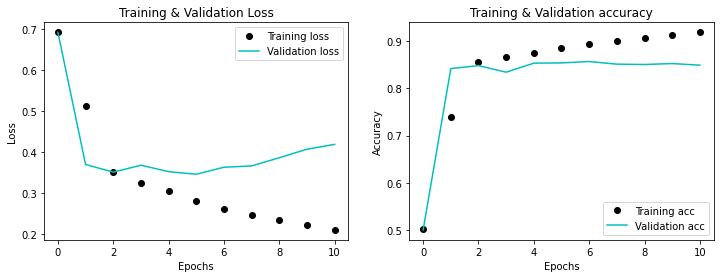

1296/1296 - 3s - loss: 0.4246 - accuracy: 0.8445
test_loss : 0.42463478446006775 test_acc : 0.8444761037826538


In [62]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 15

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[es]
                    )

history_graph(history)

results = model.evaluate(Mecab_test,  labels_test, verbose=2)
print_result(results)

정확도 또한 Okt보다 높게 나왔습니다.

컴퓨터가 읽기엔 Mecab이 더 의미 있게 형태소를 분리했다고 보는 게 좋겠군요.

- - -
### 여러 모델 비교하기
- **SentencePiece(bpe)**

마지막으로 SentencePiece의 모델 타입을 BPE로 주고 학습을 진행해보겠습니다.

과연 유의미한 성능 변화가 있을까요?

In [63]:
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --model_type=bpe --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --model_type=bpe --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_voca

-rw-r--r-- 1 root root 371936 Nov 20 07:53 korean_spm.model
-rw-r--r-- 1 root root 117142 Nov 20 07:53 korean_spm.vocab


trainer_spec의 네 번째 특성에 `model_type: BPE`가 추가된 것을 볼 수 있습니다.

In [64]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1520, 1154, 6614, 6710, 2644, 6782, 6685, 6687]
['▁아버', '지가', '방에', '들', '어가', '신', '다', '.']
아버지가방에들어가신다.


unigram : `▁아버지 가 방 에 들어 가 신 다 .`  
    bpe : `▁아버 지가 방에 들 어가 신 다 .`
    
unigram이 기본값인 이유가 있었던걸까요?

좀 더 다양한 문장으로 비교해보기 위해 일단 계속 진행해보겠습니다.

In [65]:
sp_data, word_index, index_word = sp_tokenize(s, data['document'])

sp_data

array([[  20,  173, 7416, ...,    0,    0,    0],
       [6683, 7905, 2914, ...,    0,    0,    0],
       [1636, 6829,    0, ...,    0,    0,    0],
       ...,
       [4803, 6720,  586, ...,    0,    0,    0],
       [5157, 6683, 7603, ...,    0,    0,    0],
       [2343,  143,  141, ...,    0,    0,    0]], dtype=int32)

In [66]:
min([sum(tensor) for tensor in sp_data])

13

아까부터 SentencePiece는 vocab_size 8000으로도 결측치가 발생하지 않았습니다.

아무래도 SentencePiece의 구조적 특징인 것 같네요.

In [67]:
sp_train = sp_data[:len(train_data)]
sp_test = sp_data[-len(test_data):]

labels_train = np.asarray(train_data['label']).astype('float32')
labels_test = np.asarray(test_data['label']).astype('float32')

print(sp_train.shape)
print(labels_train.shape)
print(sp_test.shape)
print(labels_test.shape)

(123860, 51)
(123860,)
(41592, 51)
(41592,)


In [68]:
for i, sen in enumerate(sp_train[:15]):
    print([index_word[idx] for idx in sen if index_word[idx] != '<unk>'], labels_train[i])

['▁아', '▁더', '빙', '..', '▁진', '짜', '▁', '짜', '증', '나', '네', '요', '▁목소', '리'] 0.0
['▁', '흠', '..', '포', '스터', '보고', '▁초', '딩', '영화', '줄', '..', '오', '버', '연', '기', '조차', '▁가', '볍', '지', '▁않', '구', '나'] 1.0
['▁너무', '재', '었다', '그', '래', '서', '보는', '것을', '추', '천', '한다'] 0.0
['▁교도', '소', '▁이야', '기구', '먼', '▁', '..', '솔', '직', '히', '▁재미', '는', '▁없다', '..', '평', '점', '▁조정'] 0.0
['▁막', '▁걸', '음', '마', '▁', '▁3', '세', '부터', '▁초', '등', '학교', '▁1', '학', '년', '생', '인', '▁8', '살', '용', '영화', '..', '별', '반', '개', '도', '▁아', '까', '움', '.'] 0.0
['▁원', '작', '의', '▁긴장', '감을', '▁제대로', '▁살', '려', '내지', '못', '했다', '.'] 0.0
['▁액', '션', '이', '▁없', '는데', '도', '▁재미', '▁있는', '▁몇', '안', '되는', '▁영화'] 1.0
['▁왜', '케', '▁평', '점이', '▁낮은', '건', '데', '?', '▁', '꽤', '▁볼', '만한', '데', '..', '▁헐', '리우드', '식', '▁화', '려', '함', '에만', '▁너무', '▁길', '들', '여', '져', '▁있', '나', '?'] 1.0
['▁', '인', '피', '니', '트가', '이다', '.', '진', '짜', '이다'] 1.0
['▁볼', '때', '마다', '▁눈', '물', '나', '서', '▁죽', '겠다', '9', '0', '년', '대의', '▁향', '수', '자', '

이것만 봐서는 아직 잘 모르겠습니다.

unigram을 썻던 모델과 비교해줄 표를 만들어보도록 하죠.

|원본|unigram|bpe|
|:---|:---|:---|
|아 더빙.. 진짜 짜증나네요 목소리|▁아 ▁더 빙 . . ▁진 짜 ▁ 짜 증 나 네 요 ▁목소리|▁아 ▁더 빙 .. ▁진 짜 ▁ 짜 증 나 네 요 ▁목소 리|
|흠..포스터보고 초딩영화줄..오버연기조차 가볍지 않구나|▁ 흠 . . 포 스터 보 고 ▁초 딩 영화 줄 . . 오 버 연 기 조차 ▁ 가 볍 지 ▁않 구 나|▁ 흠 .. 포 스터 보고 ▁초 딩 영화 줄 .. 오 버 연 기 조차 ▁가 볍 지 ▁않 구 나|
|너무재밓었다그래서보는것을추천한다|▁너무 재 었다 그 래 서 보 는 것 을 추 천 한다|▁너무 재 었다 그 래 서 보는 것을 추 천 한다|
|교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정|▁교도소 ▁이야기 구 먼 ▁ . . 솔 직 히 ▁재 미 는 ▁없다 . . 평 점 ▁조정|▁교도 소 ▁이야 기구 먼 ▁ .. 솔 직 히 ▁재미 는 ▁없다 .. 평 점 ▁조정|
|막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화..별반개도 아까움.|▁막 ▁걸 음 마 ▁ ▁3 세 부터 ▁초 등 학교 ▁1 학 년 생 인 ▁8 살 용 영화 . . 별 반 개 도 ▁아 까 움 .|▁막 ▁걸 음 마 ▁ ▁3 세 부터 ▁초 등 학교 ▁1 학 년 생 인 ▁8 살 용 영화 .. 별 반 개 도 ▁아 까 움 .|
|원작의 긴장감을 제대로 살려내지못했다.|▁원 작 의 ▁긴장 감 을 ▁ 제대로 ▁살 려 내 지 못 했다 .|▁원 작 의 ▁긴장 감을 ▁제대로 ▁살 려 내지 못 했다 .|
|액션이 없는데도 재미 있는 몇안되는 영화|▁ 액 션 이 ▁없는 데 도 ▁재 미 ▁있는 ▁몇 안 되는 ▁영화|▁액 션 이 ▁없 는데 도 ▁재미 ▁있는 ▁몇 안 되는 ▁영화|
|왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?|▁왜 케 ▁평 점 이 ▁낮은 건 데 ? ▁ 꽤 ▁볼 만한 데 . . ▁ 헐 리 우드 식 ▁화려 함 에 만 ▁너무 ▁길 들 여 져 ▁있 나 ?|▁왜 케 ▁평 점이 ▁낮은 건 데 ? ▁ 꽤 ▁볼 만한 데 .. ▁헐 리우드 식 ▁화 려 함 에만 ▁너무 ▁길 들 여 져 ▁있 나 ?|
|걍인피니트가짱이다.진짜짱이다|▁ 인 피 니 트 가 이다 . 진 짜 이다|▁ 인 피 니 트가 이다 . 진 짜 이다|
|볼때마다 눈물나서 죽겠다90년대의 향수자극!허진호는 감성절제멜로의 달인이다~|▁볼 때 마다 ▁눈물 나 서 ▁죽 겠다 90 년대 의 ▁향 수 자 극 ! 허 진 호 는 ▁감 성 절 제 멜 로 의 ▁달 인 이다 ~|▁볼 때 마다 ▁눈 물 나 서 ▁죽 겠다 9 0 년 대의 ▁향 수 자 극 ! 허 진 호는 ▁감 성 절 제 멜 로의 ▁달 인 이다 ~|
|울면서 손들고 횡단보도 건널때 뛰쳐나올뻔 이범수 연기 드럽게못해|▁울 면서 ▁손 들 고 ▁ 횡 단 보 도 ▁건 널 때 ▁뛰 쳐 나 올 뻔 ▁이 범 수 ▁연기 ▁드 럽 게 못 해|▁울 면서 ▁손 들 고 ▁횡 단 보 도 ▁건 널 때 ▁뛰 쳐 나 올 뻔 ▁이 범 수 ▁연기 ▁드 럽 게 못 해|
|담백하고 깔끔해서 좋다. 신문기사로만 보다 보면 자꾸 잊어버린다. 그들도 사람이었다는 것을.|▁담 백 하고 ▁ 깔 끔 해서 ▁ 좋 다 . ▁신문 기 사 로 만 ▁보다 ▁보면 ▁자 꾸 ▁ 잊 어 버린 다 . ▁그들 도 ▁사람이 었다 는 ▁것을 .|▁담 백 하고 ▁ 깔 끔 해서 ▁좋 다 . ▁신문 기사 로 만 ▁보다 ▁보면 ▁자 꾸 ▁잊 어버 린다 . ▁그 들도 ▁사람 이었다 는 ▁것을 .|
|냥 매번 긴장되고 재밋음|▁ 냥 ▁매 번 ▁긴장 되고 ▁재 음|▁ 냥 ▁매 번 ▁긴장 되고 ▁재 음|
|굿바이 레닌 표절인것은 이해하는데 왜 뒤로 갈수록 재미없어지냐|▁ 굿 바이 ▁레 닌 ▁표 절 인 것 은 ▁이해 하는데 ▁왜 ▁뒤 로 ▁갈 수록 ▁재 미 없 어 지 냐|▁ 굿 바이 ▁레 닌 ▁표 절 인 것은 ▁이해 하는데 ▁왜 ▁뒤 로 ▁갈 수록 ▁재미 없 어 지 냐|
|이건 정말 깨알 캐스팅과 질퍽하지않은 산뜻한 내용구성이 잘 버무러진 깨알일드!|▁이 건 ▁정말 ▁깨 알 ▁캐 스 팅 과 ▁질 퍽 하지 않 은 ▁산 뜻 한 ▁내용 구 성이 ▁잘 ▁버 무 러 진 ▁깨 알 일 드 !|▁이 건 ▁정말 ▁깨 알 ▁캐 스 팅 과 ▁질 퍽 하지 않 은 ▁산 뜻 한 ▁내용 구 성이 ▁잘 ▁버 무 러 진 ▁깨 알 일 드 !|

잘 모르겠는데요. 그냥 둘 다 형편없습니다.

그나마 unigram은 의미 있게 형태소를 분리하는 것 같긴 하나, 거의 대부분은 음절 단위로 분리해버렸습니다.

bpe는 unigram보다는 좀 더 다양한 분리가 시도되었지만 그게 의미가 없을 것 같은 분리라는 것이 흠이네요.

특히 bpe는 `.`과 `..`을 다르게 보는 것에서 인상깊었습니다.

그럼 모델에 넣어보도록 하죠.

In [69]:
val_num = 20000

X_train = sp_train[:-val_num]
y_train = labels_train[:-val_num]

X_val = sp_train[-val_num:]
y_val = labels_train[-val_num:]

print(X_train.shape)
print(X_val.shape)

(103860, 51)
(20000, 51)


In [70]:
word_vector_dim = 51

tf.random.set_seed(1337) # 시드 1337 고정

model = tf.keras.Sequential() # RNN
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3)) # 드랍아웃 추가
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 51)          408000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                4352      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 412,641
Trainable params: 412,641
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15
203/203 [==============================] - 5s 12ms/step - loss: 0.6932 - accuracy: 0.4977 - val_loss: 0.6932 - val_accuracy: 0.4994
Epoch 2/15
203/203 [==============================] - 1s 6ms/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6932 - val_accuracy: 0.4994
Epoch 3/15
203/203 [==============================] - 1s 6ms/step - loss: 0.6932 - accuracy: 0.4978 - val_loss: 0.6931 - val_accuracy: 0.5208
Epoch 4/15
203/203 [==============================] - 1s 6ms/step - loss: 0.6799 - accuracy: 0.5356 - val_loss: 0.5622 - val_accuracy: 0.7487
Epoch 5/15
203/203 [==============================] - 1s 6ms/step - loss: 0.4618 - accuracy: 0.7971 - val_loss: 0.4174 - val_accuracy: 0.8103
Epoch 6/15
203/203 [==============================] - 1s 6ms/step - loss: 0.3973 - accuracy: 0.8284 - val_loss: 0.3996 - val_accuracy: 0.8205
Epoch 7/15
203/203 [==============================] - 1s 6ms/step - loss: 0.3733 - accuracy: 0.8392 - val_loss: 0.3965 - val_accuracy: 0.8231
Epoch

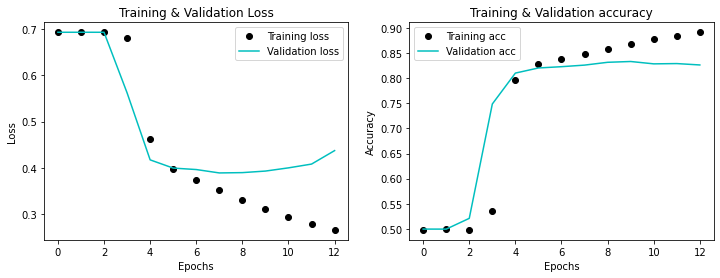

1300/1300 - 3s - loss: 0.4349 - accuracy: 0.8272
test_loss : 0.434906542301178 test_acc : 0.8271782994270325


In [71]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 15

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[es]
                    )

history_graph(history)

results = model.evaluate(sp_test,  labels_test, verbose=2)
print_result(results)

결과도 unigram에 살짝 못미칩니다.

## 마무리하며

|model|loss|accuracy|epochs|비고|
|:---|:---|:---|:---:|:---:|
|SentencePiece(unigram)|0.442817|0.831986|13||
|SentencePiece(bpe)|0.434906|0.827178|13|.과 .. 구분|
|KoNLPy(Okt)|0.412994|0.836815|8|.과 .. 구분|
|LoNLPy(Mecab)|0.424634|0.844476|11|연산 처리가 빠름|

### *SentencePiece(unigram)*

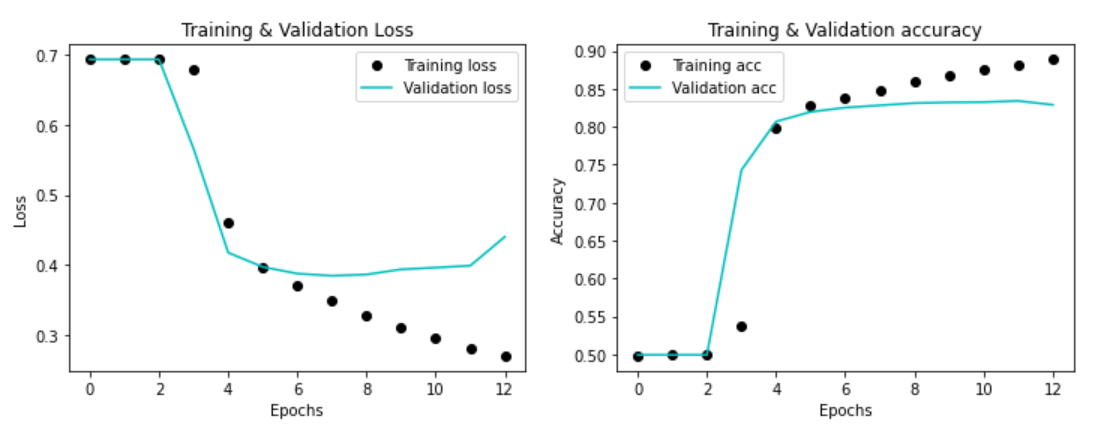

### *SentencePiece(bpe)*

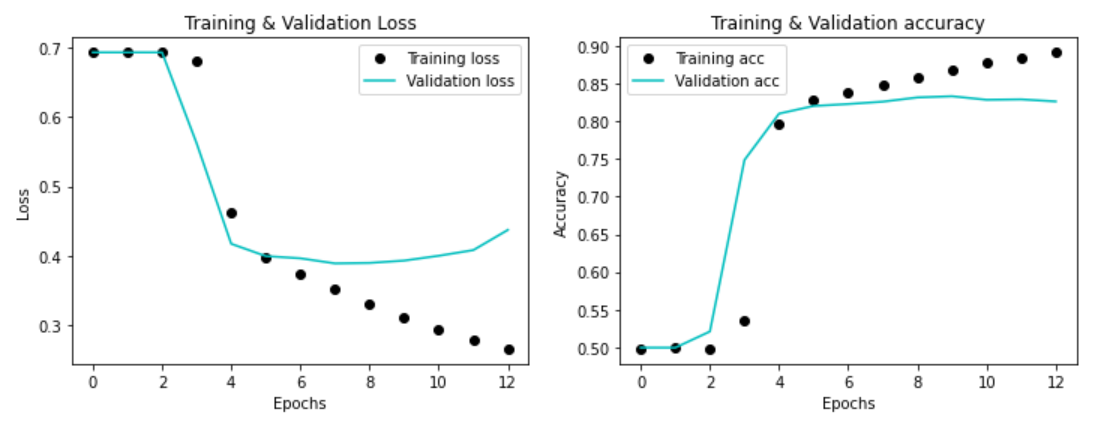

### *KoNLPy(Okt)*

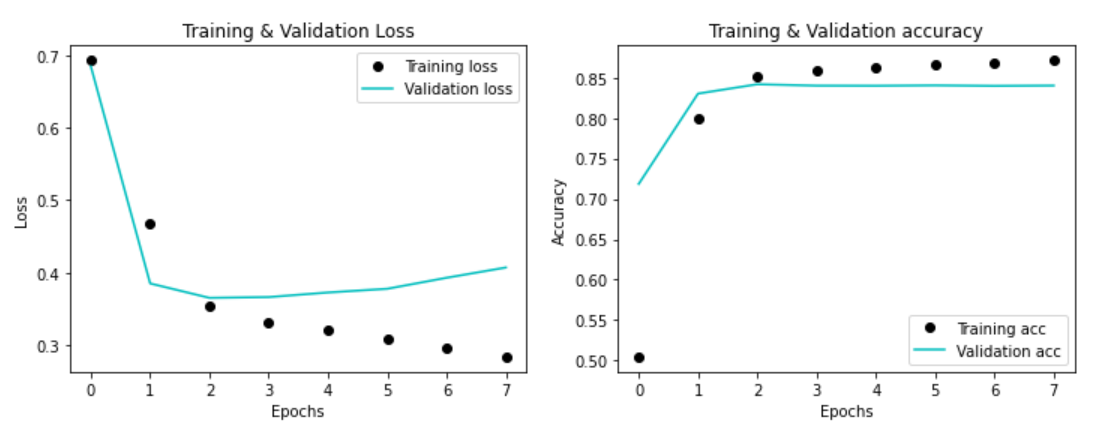

### *KoNLPy(Mecab)*

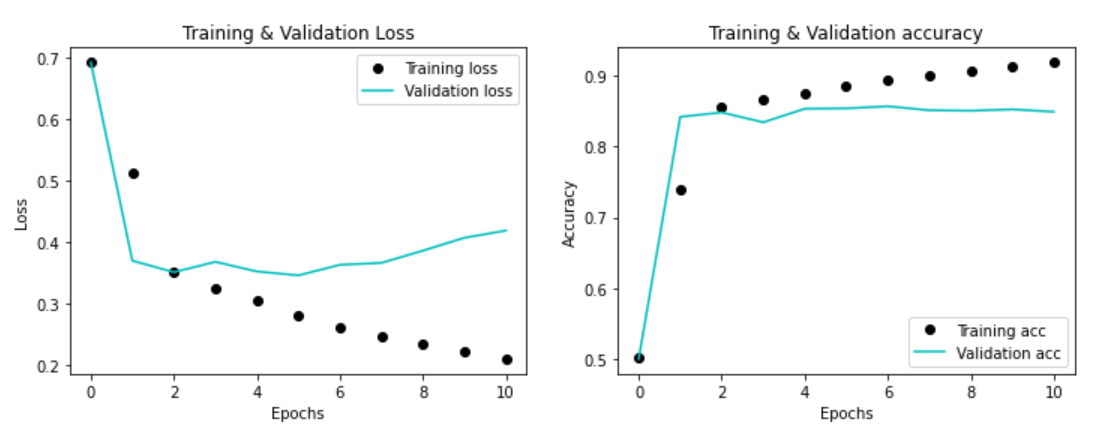

모델이 정확히 고정된 시드는 아니였지만 그래도 Mecab이 제일 좋은 듯 싶습니다.

연산 처리 속도는 다른 모델에 비해 월등히 빠르기도 했구요.

SentencePiece를 배우려고 하는 프로젝트이긴 했지만 SentencePiece는 그다지 활약하지 못했습니다.

사실 LMS에서도 나와있던 내용이지요. 잘 학습된 모델을 이기기는 힘들면서, 그럼에도 SentencePiece가 각광받는 이유까지요.

오히려 적은 학습량으로 이 정도의 수준을 보여주는 부분에 대해서 저는 높게 평가하고 있습니다.

동시에 완벽한 형태소 분리기를 만들기란 생각보다 쉽지 않을 것이란 생각도 드네요.